In [1]:
import pandas as pd

## Load Dataset

In [2]:
data = {
    'name': ["Kang", "Kim", "Choi", "Park", "Yoon"],
    '짱절미': [True, False, False, False, False],
    '셀스타그램': [False, False, True, False, False],
    '우산': [False, False, False, False, False],
    'follower': [0, 0, 100, 210, 0],
    'like': [True, False, True, True, False]
}

data = pd.DataFrame(data)
data = data.set_index("name")

print(data.shape)
data.head()

(5, 5)


,짱절미,셀스타그램,우산,follower,like
name,,,,,
Kang,True,False,False,0,True
Kim,False,False,False,0,False
Choi,False,True,False,100,True
Park,False,False,False,210,True
Yoon,False,False,False,0,False


## Preprocessing

In [3]:
label_name = "like"
label_name

'like'

In [4]:
feature_names = data.columns.difference([label_name])
feature_names

Index(['follower', '셀스타그램', '우산', '짱절미'], dtype='object')

## Prerequisites

### Visualize Tree

In [5]:
import graphviz
from graphviz import Digraph

def display_node(dot, key, node):
    if node["leaf"] == True:
        probability = node['probability']
        probability = round(probability, 4)
        probability = str(probability)
        
        dot.node(key, probability)
    else:
        description = node['description']
        dot.node(key, description)
        
        if "left" in node:
            left_key = key + "L"
            display_node(dot, left_key, node['left'])
            dot.edge(key, left_key)

        if "right" in node:
            right_key = key + "R"
            display_node(dot, right_key, node['right'])
            dot.edge(key, right_key)

def display_tree(tree):
    dot = Digraph(comment='Decision Tree')

    display_node(dot, "Root", tree)

    return graphviz.Source(dot.source)

### Predict

In [6]:
def predict(data, node):
    if node['leaf'] == True:
        probability = node["probability"]
        result = dict(zip(data.index, len(data) * [probability]))
    else:
        condition = node['condition']
        
        left_data = data[condition(data)]
        left_result = predict(left_data, node['left'])
        
        right_data = data[~condition(data)]
        right_result = predict(right_data, node['right'])    
    
        return {**left_result, **right_result}

    return result

## Implement a Decision Tree

### Make Conditions

In [17]:
def binary_condition(data, feature_name, value):
    return data[feature_name] == value

def continuous_condition(data, feature_name, value):
    return data[feature_name] < value

def make_condition(method, feature_name, value):
    def call_condition(data):
        return method(data, feature_name, value)
    
    return call_condition

In [18]:
condition = make_condition(binary_condition, "짱절미", True)
data[condition(data)]

,짱절미,셀스타그램,우산,follower,like
name,,,,,
Kang,True,False,False,0,True


In [19]:
condition = make_condition(continuous_condition, "follower", 150)
data[condition(data)]

,짱절미,셀스타그램,우산,follower,like
name,,,,,
Kang,True,False,False,0,True
Kim,False,False,False,0,False
Choi,False,True,False,100,True
Yoon,False,False,False,0,False


In [20]:
def make_condition_list(data, feature_names):
    condition_list = {}

    for feature_name in feature_names:
        if data[feature_name].dtype == "bool":
            description = f"{feature_name} == True"
            condition = make_condition(binary_condition, feature_name, True)

            condition_list[description] = condition
        else:
            values = data[feature_name].unique()
            values = values[1:-1]

            for value in values:
                description = f"{feature_name} < {value}"
                condition = make_condition(continuous_condition, feature_name, value)

                condition_list[description] = condition

    return condition_list

In [21]:
condition_list = make_condition_list(data, feature_names)
condition_list

{'follower < 100': <function __main__.make_condition.<locals>.call_condition(data)>,
 '셀스타그램 == True': <function __main__.make_condition.<locals>.call_condition(data)>,
 '우산 == True': <function __main__.make_condition.<locals>.call_condition(data)>,
 '짱절미 == True': <function __main__.make_condition.<locals>.call_condition(data)>}

### Evaluate Gini Impurity

$$
{\displaystyle I_{G}(p)=\sum _{i=1}^{J}p_{i}(1-p_{i})=p_{t}(1-p_{t}) + p_{f}(1-p_{f})}
$$

In [22]:
def evaluate_gini_impurity(data, label_name):
    if len(data) == 0:
        return 0

    true_probability = data[label_name].mean()
    false_probability = 1 - true_probability

    true_gini_impurity = true_probability * (1 - true_probability)
    false_gini_impurity = false_probability * (1 - false_probability)

    gini_impurity = true_gini_impurity + false_gini_impurity

    return gini_impurity

In [23]:
evaluate_gini_impurity(data, label_name)

0.48

In [24]:
evaluate_gini_impurity([], label_name)

0

In [25]:
def evaluate_average_gini_impurity(data, condition, label_name):
    true_data = data[condition(data)]
    false_data = data[~condition(data)]

    true_impurity = evaluate_gini_impurity(true_data, label_name)
    false_impurity = evaluate_gini_impurity(false_data, label_name)

    gini_impurity = (len(true_data) * true_impurity + len(false_data) * false_impurity)
    gini_impurity = gini_impurity / len(data)

    return gini_impurity

In [26]:
condition = make_condition(binary_condition, "짱절미", True)
evaluate_average_gini_impurity(data, condition, label_name)

0.4

In [27]:
condition = make_condition(binary_condition, "셀스타그램", True)
evaluate_average_gini_impurity(data, condition, label_name)

0.4

In [28]:
condition = make_condition(binary_condition, "우산", True)
evaluate_average_gini_impurity(data, condition, label_name)

0.48

In [29]:
def find_best_condition(data, condition_list, label_name):
    best_gini_impurity = 0.51
    best_condition = None
    best_description = None

    for description, condition in condition_list.items():
        gini_impurity = evaluate_average_gini_impurity(data, condition, label_name)

        if gini_impurity < best_gini_impurity:
            best_gini_impurity = gini_impurity
            best_condition = condition
            best_description = description

    return best_condition, best_description, best_gini_impurity

In [30]:
condition1 = make_condition(binary_condition, "짱절미", True)
condition2 = make_condition(binary_condition, "셀스타그램", True)
condition3 = make_condition(binary_condition, "우산", True)

condition_list = {
    "짱절미 == True": condition1,
    "셀스타그램 == True": condition2,
    "우산 == True": condition3,
}

find_best_condition(data, condition_list, label_name)

(<function __main__.make_condition.<locals>.call_condition(data)>,
 '짱절미 == True',
 0.4)

### Make a Tree

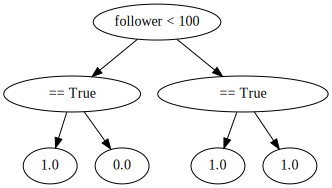

In [31]:
max_depth = None
min_sample_split = 2

def make_node(data, condition_list, current_gini, current_depth):
    condition = (len(condition_list) != 0)
    sample = (len(data) >= min_sample_split)
    depth = (max_depth == None) or (current_depth < max_depth)
    
    if condition and sample and depth:
        condition, description, gini = \
            find_best_condition(data, condition_list, label_name)

        left_data = data[condition(data)]
        right_data = data[~condition(data)]
        
        if gini < current_gini and len(left_data) != 0 and len(right_data) != 0:
            node = {'leaf': False, 'description': description, 'condition': condition}

            del condition_list[description]

            node['left'] = make_node(left_data, condition_list.copy(), gini, current_depth + 1)
            node['right'] = make_node(right_data, condition_list.copy(), gini, current_depth + 1)

            return node

    probability = data[label_name].mean()
    node = {'leaf': True, 'probability': probability}

    return node

    
def make_tree(data, feature_names):
    condition_list = make_condition_list(data, feature_names)

    tree = make_node(data, condition_list, current_gini = 0.51, current_depth=0)

    return tree

tree = make_tree(data, feature_names)
display_tree(tree)

In [32]:
predictions = predict(data, tree)
predictions = pd.Series(predictions)

result = data.copy()
result["like(predict)"] = predictions

result

,짱절미,셀스타그램,우산,follower,like,like(predict)
name,,,,,,
Kang,True,False,False,0,True,1.0
Kim,False,False,False,0,False,0.0
Choi,False,True,False,100,True,1.0
Park,False,False,False,210,True,1.0
Yoon,False,False,False,0,False,0.0


## Implement Random Forest

### Boostrap data

In [66]:
# import numpy as np

# def bootstrap(original_data):
#     index = np.random.choice(original_data.index, size=len(data))
#     return data.loc[index]

# bootstrap(data)

In [75]:
import numpy as np

def bootstrap(data, feature_names, label_name, max_feature = None):
    feature_data = data[feature_names]
    
    num_rows, num_cols = feature_data.shape
    
    index = np.random.choice(feature_data.index, size=num_rows, replace=True)
    
    if max_feature == None:
        num_cols = np.sqrt(num_cols)
    else:
        num_cols = num_cols * max_feature
    num_cols = int(num_cols)
    
    columns = np.random.choice(feature_data.columns, size=num_cols, replace=False)
    
    result = feature_data.loc[index, columns]
    result[label_name] = data[label_name]
    
    return result

In [76]:
bootstrap(data, feature_names, label_name, max_feature=0.8)

,우산,짱절미,셀스타그램,like
name,,,,
Park,False,False,False,True
Park,False,False,False,True
Kim,False,False,False,False
Yoon,False,False,False,False
Yoon,False,False,False,False


### Make Forest

In [79]:
def make_forest(data, n_estimators):
    forest = []
    for _ in range(n_estimators):
        bootstraped_data = bootstrap(data, feature_names, label_name)
        
        bootstrapped_feature_names = bootstraped_data.columns.difference([label_name])
        
        tree = make_tree(bootstraped_data, bootstrapped_feature_names)
        
        forest.append(tree)
    
    return forest

100


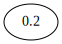

In [87]:
forest = make_forest(data, n_estimators=100)

print(len(forest))
display_tree(forest[0])

In [88]:
def predict_forest(data, forest):
    prediction_total = []
    
    for tree in forest:
        prediction = predict(data, tree)
        prediction = pd.Series(prediction)
        
        prediction_total.append(prediction)
    
    prediction_total = pd.concat(prediction_total, sort=False, axis=1)
    prediction_total = prediction_total.mean(axis=1)
    
    return prediction_total                               

In [89]:
predict_forest(data, forest)

Kang    0.641500
Kim     0.479833
Choi    0.684000
Park    0.541500
Yoon    0.479833
dtype: float64